## Pre Proccessing


In [27]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import sys
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
import sys
!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
print(sns.__version__)





# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

train_filter = (y_train == 0) | (y_train == 1)
test_filter = (y_test == 0) | (y_test == 1)

X_train_binary = X_train[train_filter]
y_train_binary = y_train[train_filter]
X_test_binary = X_test[test_filter]
y_test_binary = y_test[test_filter]

X_train_binary = X_train_binary / 255.0
X_test_binary = X_test_binary / 255.0

X_train_binary = X_train_binary.reshape(-1, 28*28)
X_test_binary = X_test_binary.reshape(-1, 28*28)

y_train_binary = np.where(y_train_binary == 0, 0, 1)
y_test_binary = np.where(y_test_binary == 0, 0, 1)

X_val_binary, X_test_binary, y_val_binary, y_test_binary = train_test_split(X_test_binary, y_test_binary, test_size=0.6, random_state=42)
X_train_binary.shape, y_train_binary.shape, X_val_binary.shape, y_val_binary.shape, X_test_binary.shape, y_test_binary.shape

((12665, 784), (12665,), (846, 784), (846,), (1269, 784), (1269,))

In [28]:
hidden_layers = int(input("Enter the number of hidden layers: "))
neurons_per_layer = []
for i in range(hidden_layers):
    neurons_per_layer.append(int(input(f"Enter the number of neurons for layer {i+1}: ")))

activation_function = input("Enter the activation function for hidden layers (sigmoid/relu): ").strip().lower()

In [29]:
def derivative_activation_function(z, func):
    if func == 'sigmoid':
        sig = 1 / (1 + np.exp(-z))
        return sig * (1 - sig)
    elif func == 'relu':
        return np.where(z > 0, 1, 0)
    elif func == 'tanh':
        return 1 - np.tanh(z)**2
    else:
        raise ValueError("Unsupported activation function")

In [30]:
def forward_propagation(X, weights, biases, activation_function):
    a = X
    zs = []
    activations = [X]
    for l in range(len(weights)):
        z = weights[l] @ a + biases[l]
        zs.append(z)
        if (l == len(weights) - 1):
            a = 1 / (1 + np.exp(-z))
        else:
            if activation_function == 'sigmoid':
                a = 1 / (1 + np.exp(-z))
            elif activation_function == 'relu':
                a = np.maximum(0, z)
            elif activation_function == 'tanh':
                a = np.tanh(z)
            else:
                raise ValueError("Unsupported activation function")
        activations.append(a)
    return zs, activations

In [31]:
def back_propagation(zs, activations, weights, y, activation_function):
    deltas = [None] * len(weights)
    deltas[-1] = activations[-1] - y
    for l in range(len(deltas) - 2, -1, -1):
        deltas[l] = (weights[l + 1].T @ deltas[l + 1]) * derivative_activation_function(zs[l], activation_function)
    weights_gradients = []
    biases_gradients = []
    for l in range(len(deltas)):
        weights_gradients.append(deltas[l] @ activations[l].T)
        biases_gradients.append(np.sum(deltas[l], axis=1, keepdims=True))
    return weights_gradients, biases_gradients

In [32]:
def update_parameters(weights, biases, weights_gradients, biases_gradients, learning_rate):
    for l in range(len(weights)):
        weights[l] -= learning_rate * weights_gradients[l]
        biases[l] -= learning_rate * biases_gradients[l]
    return weights, biases

In [33]:
def train_neural_network(X_train, y_train, X_val, y_val, hidden_layers, neurons_per_layer, activation_function, epochs=1000, learning_rate=0.01, batch_size=64):
    input_size = X_train.shape[1]
    output_classes = 1
    weights = []
    biases = []
    layers = [input_size] + neurons_per_layer + [output_classes]
    train_losses = []
    train_accuracys = []
    validation_losses = []
    validation_accuracys = []
    for i in range(1, hidden_layers + 2):
        w = np.random.randn(layers[i], layers[i - 1]) * 0.01
        b = np.zeros((layers[i], 1))
        weights.append(w)
        biases.append(b)
    # show initial accuracy
    _, train_activations = forward_propagation(X_train.T, weights, biases, activation_function)
    train_predictions = (train_activations[-1] > 0.5).astype(int)
    train_accuracy = np.mean(train_predictions.flatten() == y_train_binary) * 100
    print(f"Initial Accuracy: {train_accuracy:.2f}%")
    for epoch in range(epochs):
        permutation = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[permutation]
        y_shuffled = y_train[permutation]
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i + batch_size].T
            y_batch = y_shuffled[i:i + batch_size].reshape(1, -1)
            zs, activations = forward_propagation(X_batch, weights, biases, activation_function)
            weights_gradients, biases_gradients = back_propagation(zs, activations, weights, y_batch, activation_function)
            weights, biases = update_parameters(weights, biases, weights_gradients, biases_gradients, learning_rate)
        # show accuracy per epoch
        _, train_activations = forward_propagation(X_train.T, weights, biases, activation_function)
        train_predictions = (train_activations[-1] > 0.5).astype(int)
        train_accuracy = np.mean(train_predictions.flatten() == y_train) * 100
        train_accuracys.append(train_accuracy)
        _, validation_activations = forward_propagation(X_val.T, weights, biases, activation_function)
        validation_predictions = (validation_activations[-1] > 0.5).astype(int)
        validation_accuracy = np.mean(validation_predictions.flatten() == y_val) * 100
        validation_accuracys.append(validation_accuracy)
        print(f"Epoch {epoch + 1}, Accuracy: {train_accuracy:.6f}%, Validation Accuracy: {validation_accuracy:.6f}%")
        # show loss per epoch
        train_loss = -np.mean(y_train * np.log(train_activations[-1] + 1e-8) + (1 - y_train) * np.log(1 - train_activations[-1] + 1e-8))
        train_losses.append(train_loss)
        validation_loss = -np.mean(y_val * np.log(validation_activations[-1] + 1e-8) + (1 - y_val) * np.log(1 - validation_activations[-1] + 1e-8))
        validation_losses.append(validation_loss)
        print(f"Epoch {epoch + 1}, Loss: {train_loss:.6f}, Validation Loss: {validation_loss:.6f}")
    return weights, biases, train_losses, train_accuracys, validation_losses, validation_accuracys

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
def extract_features(X_train):
    model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))
    X_train = X_train.reshape(-1, 28, 28)
    X_train = np.expand_dims(X_train, axis=-1)
    resized_images = tf.image.resize(X_train, [32, 32])
    resized_images = tf.repeat(resized_images, 3, axis=-1)
    preprocessed_images = preprocess_input(resized_images)
    features = model.predict(preprocessed_images)
    return features

In [35]:
extracted_features = extract_features(X_train_binary)
extracted_val_features = extract_features(X_val_binary)
weights, biases, train_losses, train_accuracys, validation_losses, validation_accuracys = train_neural_network(extracted_features, y_train_binary, extracted_val_features, y_val_binary, hidden_layers, neurons_per_layer, activation_function, 100,learning_rate=0.03)

C:\Users\abdlm\AppData\Local\Temp\ipykernel_38024\2288237362.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))


396/396 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
Initial Accuracy: 46.77%
Epoch 1, Accuracy: 53.233320%, Validation Accuracy: 57.210402%
Epoch 1, Loss: 0.692132, Validation Loss: 0.683277
Epoch 2, Accuracy: 53.233320%, Validation Accuracy: 57.210402%
Epoch 2, Loss: 0.698951, Validation Loss: 0.683743
Epoch 3, Accuracy: 53.233320%, Validation Accuracy: 57.210402%
Epoch 3, Loss: 0.691307, Validation Loss: 0.684364
Epoch 4, Accuracy: 53.233320%, Validation Accuracy: 57.210402%
Epoch 4, Loss: 0.691875, Validation Loss: 0.683493
Epoch 5, Accuracy: 46.766680%, Validation Accuracy: 42.789598%
Epoch 5, Loss: 0.698633, Validation Loss: 0.703281
Epoch 6, Accuracy: 53.233320%, Validation Accuracy: 57.210402%
Epoch 6, Loss: 0.691236, Validation Loss: 0.684567
Epoch 7, Accuracy: 53.233320%, Validation Accuracy: 57.210402%
Epoch 7, Loss: 0.691147, Validation Loss: 0.687075
Epoch 8, Accuracy: 53.233320%, Validation Accuracy: 57.210402%
Epoch 8, Loss: 0.691435, Valida

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Input
model = Sequential([
    Input(shape=(extracted_features.shape[1],)),
    *[Dense(neurons, activation=activation_function) for neurons in neurons_per_layer],
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(extracted_features, y_train_binary, epochs=100, batch_size=64)

Epoch 1/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6908 - loss: 0.6468
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8137 - loss: 0.5601
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8493 - loss: 0.4932
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8659 - loss: 0.4407
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8782 - loss: 0.3982
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8876 - loss: 0.3625
Epoch 7/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8972 - loss: 0.3325
Epoch 8/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9040 - loss: 0.3066
Epoch 9/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9111 - loss: 0.2842
Epoch 10/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9199 - loss: 0.2645
Epoch 11/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9263 - loss: 0.2470
Epoch 12/100
198/198 ━━━━━━━━━━━━━━━━━━━━

In [37]:
def predict(X, weights, biases, activation_function):
    _, activations = forward_propagation(X.T, weights, biases, activation_function)
    predictions = (activations[-1] > 0.5).astype(int)
    return predictions.flatten()

In [38]:
extracted_test_features = extract_features(X_test_binary)
predictions = predict(extracted_test_features, weights, biases, activation_function)
accuracy = np.mean(predictions == y_test_binary) * 100
accuracy

C:\Users\abdlm\AppData\Local\Temp\ipykernel_38024\2288237362.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(32, 32, 3))


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


np.float64(51.30023640661938)

In [39]:
def plot_results(train_losses, train_accuracys, validation_losses, validation_accuracys):
    import matplotlib.pyplot as plt
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracys, label='Training Accuracy')
    plt.plot(epochs, validation_accuracys, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

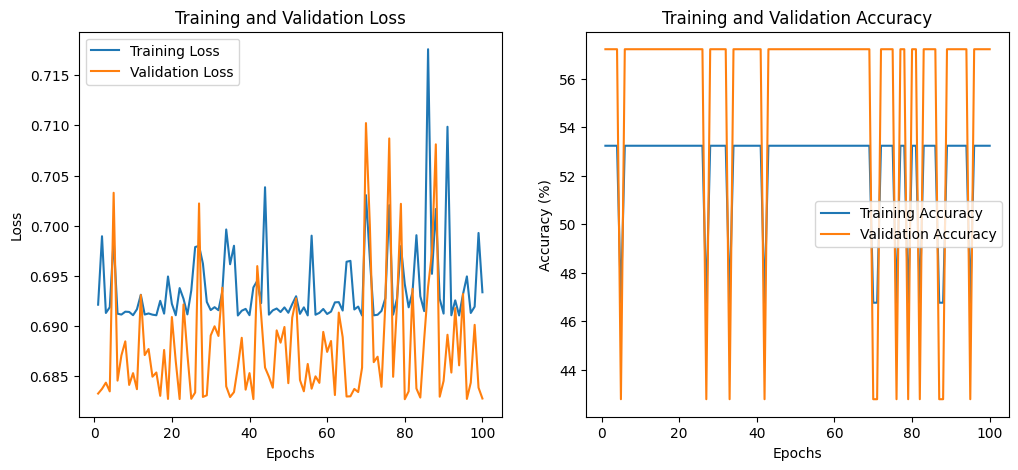

In [40]:
plot_results(train_losses, train_accuracys, validation_losses, validation_accuracys)

## • Compare the results of the built in model and from scratch model


In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



c:\Users\abdlm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdlm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdlm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

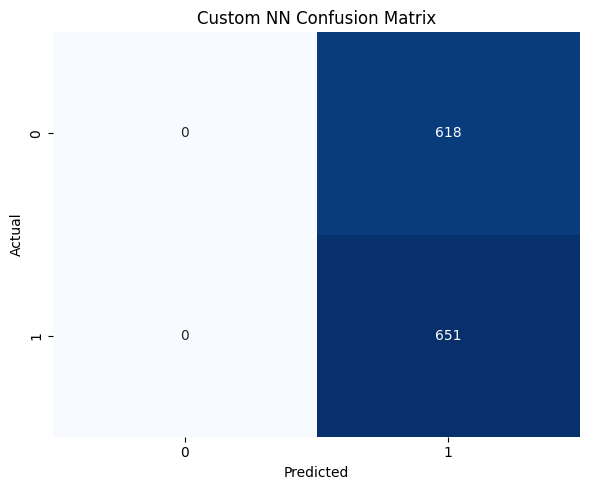

Custom Model Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       618
           1       0.51      1.00      0.68       651

    accuracy                           0.51      1269
   macro avg       0.26      0.50      0.34      1269
weighted avg       0.26      0.51      0.35      1269



In [42]:
custom_predictions = predict(extracted_test_features, weights, biases, activation_function)

# Classification report for custom model
custom_classification_report = classification_report(y_test_binary, custom_predictions)

# Confusion matrix for custom model
custom_cm = confusion_matrix(y_test_binary, custom_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(custom_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Custom NN Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Print the classification report for custom model
print("Custom Model Classification Report:\n", custom_classification_report)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


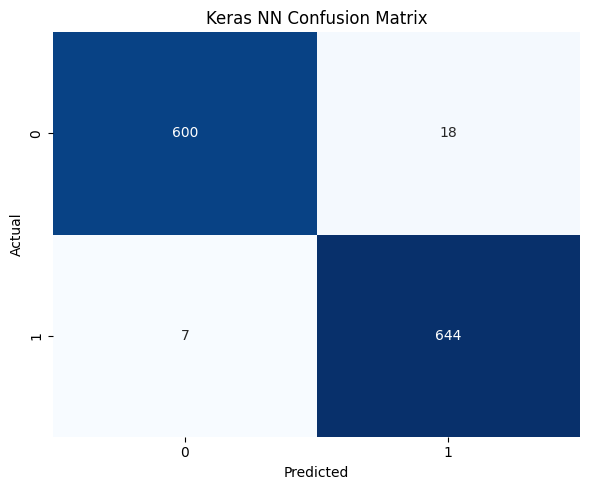

Keras Model Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       618
           1       0.97      0.99      0.98       651

    accuracy                           0.98      1269
   macro avg       0.98      0.98      0.98      1269
weighted avg       0.98      0.98      0.98      1269



In [43]:
keras_predictions = model.predict(extracted_test_features)
keras_predictions = (keras_predictions > 0.5).astype(int)

keras_classification_report = classification_report(y_test_binary, keras_predictions)

keras_cm = confusion_matrix(y_test_binary, keras_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(keras_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Keras NN Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("Keras Model Classification Report:\n", keras_classification_report)

## Optimization Part

### Random Search

In [44]:
import random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

# Define the hyperparameter grid for Random Search
param_grid = {
    'hidden_layers': [1, 2, 3, 4, 5],
    'neurons_per_layer': [32, 64, 128, 256, 512],
    'activation_function': ['relu', 'sigmoid', 'tanh'],
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'batch_size': [16, 32, 64, 128],
    'optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad'],
    'epochs': [3, 15, 20]
}

def get_optimizer(optimizer_name, learning_rate):
    if optimizer_name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        return SGD(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adagrad':
        return Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

def build_keras_model(hidden_layers, neurons_per_layer, activation_function, learning_rate, optimizer):
    model = Sequential()
    model.add(Input(shape=(X_train_binary.shape[1],)))  # Input layer
    # Add hidden layers
    for _ in range(hidden_layers):
        model.add(Dense(units=neurons_per_layer, activation=activation_function))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    optimizer_obj = get_optimizer(optimizer, learning_rate)
    model.compile(optimizer=optimizer_obj, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def random_search_keras(X_train, y_train, num_trials=3):
    best_accuracy = 0
    best_hyperparameters = None
    best_model = None

    for trial in range(num_trials):
        print(f"Trial {trial + 1} / {num_trials}")
        
        hidden_layers = random.choice(param_grid['hidden_layers'])
        neurons_per_layer = random.choice(param_grid['neurons_per_layer'])
        activation_function = random.choice(param_grid['activation_function'])
        learning_rate = random.choice(param_grid['learning_rate'])
        batch_size = random.choice(param_grid['batch_size'])
        optimizer = random.choice(param_grid['optimizer'])
        epochs = random.choice(param_grid['epochs'])
        
        print(f"Training with hyperparameters: {hidden_layers} hidden layers, {neurons_per_layer} neurons per layer, {activation_function} activation function, learning rate {learning_rate}, batch size {batch_size}, optimizer {optimizer}, epochs {epochs}")
        
        model = build_keras_model(hidden_layers, neurons_per_layer, activation_function, learning_rate, optimizer)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)  
        
        train_accuracy = history.history['accuracy'][-1] 
        print(f"Training Accuracy: {train_accuracy:.2f}%")

        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            best_hyperparameters = {
                'hidden_layers': hidden_layers,
                'neurons_per_layer': neurons_per_layer,
                'activation_function': activation_function,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'optimizer': optimizer,
                'epochs': epochs
            }
            best_model = model

    return best_hyperparameters, best_accuracy, best_model

best_hyperparameters, best_accuracy, best_model = random_search_keras(X_train_binary, y_train_binary)
print("Best Hyperparameters found by Random Search:", best_hyperparameters)
print(f"Best Training Accuracy: {best_accuracy:.2f}%")

Trial 1 / 3
Training with hyperparameters: 5 hidden layers, 64 neurons per layer, tanh activation function, learning rate 0.001, batch size 16, optimizer adagrad, epochs 20
Epoch 1/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9815 - loss: 0.0895
Epoch 2/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9977 - loss: 0.0153
Epoch 3/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9976 - loss: 0.0107
Epoch 4/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9979 - loss: 0.0086
Epoch 5/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9983 - loss: 0.0074
Epoch 6/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9987 - loss: 0.0065
Epoch 7/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9987 - loss: 0.0059
Epoch 8/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9989 - loss: 0.0054
Epoch 9/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9991 - loss: 0.0050
Epoch 10/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

In [47]:
def grid_search(X_train, y_train, X_val, y_val):
    best_acc = 0
    best_solution = None
    results = []
    trial = 0

    for hidden_layers in [1]:
        for neurons in [64]:
            for activation in ['relu', 'tanh']:
                for lr in [1e-3]:
                    for batch_size in [32]:
                        for optimizer in ['adam', 'sgd']:
                            for epochs in [5, 10]:

                                trial += 1
                                print(f"Trial {trial}: "
                                      f"layers={hidden_layers}, neurons={neurons}, "
                                      f"act={activation}, lr={lr}, "
                                      f"batch={batch_size}, opt={optimizer}, "
                                      f"epochs={epochs}")

                                model = build_keras_model(
                                    hidden_layers,
                                    neurons,
                                    activation,
                                    lr,
                                    optimizer
                                )

                                model.fit(
                                    X_train, y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    verbose=0
                                )

                                _, val_acc = model.evaluate(X_val, y_val, verbose=0)
                                print(f" → Validation Accuracy: {val_acc:.4f}\n")

                                solution = {
                                    'hidden_layers': hidden_layers,
                                    'neurons': neurons,
                                    'activation': activation,
                                    'lr': lr,
                                    'batch_size': batch_size,
                                    'optimizer': optimizer,
                                    'epochs': epochs
                                }

                                results.append((solution, val_acc))

                                if val_acc > best_acc:
                                    best_acc = val_acc
                                    best_solution = solution

    return best_solution, best_acc, results

best_solution, best_acc, results = grid_search(X_train_binary, y_train_binary, X_val_binary, y_val_binary)
print("Best Solution from Grid Search:", best_solution)
print(f"Best Validation Accuracy: {best_acc:.4f}")

Trial 1: layers=1, neurons=64, act=relu, lr=0.001, batch=32, opt=adam, epochs=5
 → Validation Accuracy: 0.9988

Trial 2: layers=1, neurons=64, act=relu, lr=0.001, batch=32, opt=adam, epochs=10
 → Validation Accuracy: 0.9988

Trial 3: layers=1, neurons=64, act=relu, lr=0.001, batch=32, opt=sgd, epochs=5
 → Validation Accuracy: 0.9965

Trial 4: layers=1, neurons=64, act=relu, lr=0.001, batch=32, opt=sgd, epochs=10
 → Validation Accuracy: 0.9988

Trial 5: layers=1, neurons=64, act=tanh, lr=0.001, batch=32, opt=adam, epochs=5
 → Validation Accuracy: 0.9988

Trial 6: layers=1, neurons=64, act=tanh, lr=0.001, batch=32, opt=adam, epochs=10
 → Validation Accuracy: 0.9988

Trial 7: layers=1, neurons=64, act=tanh, lr=0.001, batch=32, opt=sgd, epochs=5
 → Validation Accuracy: 0.9976

Trial 8: layers=1, neurons=64, act=tanh, lr=0.001, batch=32, opt=sgd, epochs=10
 → Validation Accuracy: 0.9976

Best Solution from Grid Search: {'hidden_layers': 1, 'neurons': 64, 'activation': 'relu', 'lr': 0.001, '

Comparison of Accuracy:

Grid Search: Best validation accuracy = 0.9988

Random Search: Best training accuracy = 1.0

Conclusion:
Random Search achieved slightly higher accuracy because it explored more complex networks and different hyperparameters, while Grid Search found a high but slightly lower accuracy due to a limited search space.